# QM7 Dataset

## Description

This dataset is a subset of GDB-13 (a database of nearly 1 billion stable and synthetically accessible organic molecules) composed of all molecules of up to 23 atoms (including 7 heavy atoms C, N, O, and S), totalling 7165 molecules.

The dataset is composed of three multidimensional arrays X (7165 x 23 x 23), T (7165) and P (5 x 1433) representing the inputs (Coulomb matrices), the labels (atomization energies) and the splits for cross-validation, respectively. The dataset also contain two additional multidimensional arrays Z (7165) and R (7165 x 3) representing the atomic charge and the cartesian coordinate of each atom in the molecules.

## Idea of my implementation

- Use the arrays Z (atomic charge) and R (cartesian coordinate) to generate a `.xyz` file
- Convert this `.xyz` file to molecular graph structure data
- GCN on graph structure data

## 1. Generate 7165 `.xyz` file

In [97]:
import scipy.io
import numpy as np

qm7 = scipy.io.loadmat('qm7.mat')
R = qm7['R']
Z = qm7['Z']
T = qm7['T'][0]

In [98]:
charge_to_atom = {
    1 : 'H',
    6 : 'C',
    7 : 'N',
    8 : 'O',
    16: 'S'
}

# unit Bohr to A
BohrToA = 0.529177249

In [99]:
for i in range(len(Z)):
    filename = f"xyz_file/qm7_xyz_{i+1}.xyz"
    atoms = []
    coordinates = []
    with open(filename, "w") as xyz:
        for j in range(len(Z[i])):
            if int(Z[i][j]) != 0:
                atoms.append(charge_to_atom[int(Z[i][j])])
                coordinates.append(R[i][j]*BohrToA)
        xyz.write(f"{len(atoms)}\n\n")
        for k in range(len(atoms)):
            xyz.write(f"{atoms[k]}  {coordinates[k][0]:.10f} {coordinates[k][1]:.10f} {coordinates[k][2]:.10f}\n")

## Convert `.xyz` file to MolGraph

In [100]:
import rdkit
from rdkit import Chem
from rdkit.Chem import rdmolfiles
from rdkit.Chem import AllChem

In [101]:
# convert each xyz to molecular graph
mols = []
for i in range(7165):
    filename = f"xyz_file/qm7_xyz_{i+1}.xyz"
    mol = rdmolfiles.MolFromXYZFile(filename)
    mols.append(mol)

In [102]:
# from rdkit.Chem import Draw
# from rdkit.Chem.Draw import IPythonConsole
# IPythonConsole.ipython_3d = True

In [103]:
# # make 3d mol graph
# import py3Dmol
# def draw_with_spheres(mol):
#     v = py3Dmol.view(width=300,height=300)
#     IPythonConsole.addMolToView(mol,v)
#     v.zoomTo()
#     v.setStyle({'sphere':{'radius':0.3},'stick':{'radius':0.2}});
#     v.show()

In [104]:
# determine chemical bonds between each atom

from rdkit.Chem import rdDetermineBonds

for mol in mols: rdDetermineBonds.DetermineBonds(mol, charge=0)

## Graph Convolutional Network

In [105]:
# import required packages for graph convolutional network
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric import nn as gnn
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader

In [106]:
# build a 5-layer graph convolutional network (GCN) containing edge_index and edge_attr
# return the predicted energy of each molecule
class GCN(nn.Module):
    def __init__(self, num_features, num_classes):
        super(GCN, self).__init__()
        self.conv1 = gnn.GCNConv(num_features, 64)
        self.conv2 = gnn.GCNConv(64, 64)
        self.conv3 = gnn.GCNConv(64, 64)
        self.conv4 = gnn.GCNConv(64, 64)
        self.conv5 = gnn.GCNConv(64, 64)
        self.fc = nn.Linear(64, num_classes)

    def forward(self, data):
        x, edge_index, edge_attr = data.x, data.edge_index, data.edge_attr
        x = F.relu(self.conv1(x, edge_index, edge_attr))
        x = F.relu(self.conv2(x, edge_index, edge_attr))
        x = F.relu(self.conv3(x, edge_index, edge_attr))
        x = F.relu(self.conv4(x, edge_index, edge_attr))
        x = F.relu(self.conv5(x, edge_index, edge_attr))
        x = gnn.global_mean_pool(x, data.batch)
        x = self.fc(x)
        return x

In [107]:
# Calculate adjacency matrices for each molecule
adj_matrices = []
for mol in mols:
    adj_matrix = Chem.rdmolops.GetAdjacencyMatrix(mol)
    adj_matrices.append(adj_matrix)

# Make sure all adjacency matrices have the same dimension
max_atoms = max([adj.shape[0] for adj in adj_matrices])
for i in range(len(adj_matrices)):
    pad_width = max_atoms - adj_matrices[i].shape[0]
    adj_matrices[i] = np.pad(adj_matrices[i], pad_width=((0, pad_width), (0, pad_width)), mode='constant', constant_values=0)

# Calculate edge indices for each molecule
edge_indices = []
for adj in adj_matrices:
    edge_index = np.array(np.where(adj == 1)).T
    edge_indices.append(edge_index)

# Make sure all edge indices have the same dimension
max_edges = max([edge_index.shape[0] for edge_index in edge_indices])
for i in range(len(edge_indices)):
    pad_width = max_edges - edge_indices[i].shape[0]
    edge_indices[i] = np.pad(edge_indices[i], pad_width=((0, pad_width), (0, 0)), mode='constant', constant_values=0)

# Calculate edge attributes for each molecule
edge_attrs = []
for mol in mols:
    edge_attr = []
    for bond in mol.GetBonds():
        edge_attr.append(bond.GetBondTypeAsDouble())
    edge_attrs.append(edge_attr)

# Pad edge attributes corresponding to non-existing edges with zeros
for i in range(len(edge_attrs)):
    pad_width = max_edges - len(edge_attrs[i])
    edge_attrs[i] = np.pad(edge_attrs[i], pad_width=(0, pad_width), mode='constant', constant_values=0)

# Calculate node features for each molecule
node_features = []
for mol in mols:
    node_feature = []
    for atom in mol.GetAtoms():
        node_feature.append(atom.GetAtomicNum())
    node_features.append(node_feature)

# Make sure all node features have the same dimension (number of atoms, 1)
max_atoms = max([len(node_feature) for node_feature in node_features])
for i in range(len(node_features)):
    pad_width = max_atoms - len(node_features[i])
    node_features[i] = np.pad(node_features[i], pad_width=(0, pad_width), mode='constant', constant_values=0)

# Make a list of torch_geometric.data.Data objects
data_list = []
for i in range(len(mols)):
    data = Data(x=torch.tensor(node_features[i], dtype=torch.float).unsqueeze(1), 
                edge_index=torch.tensor(edge_indices[i], dtype=torch.long).T, 
                edge_attr=torch.tensor(edge_attrs[i], dtype=torch.float).unsqueeze(1), 
                y=torch.tensor(T[i], dtype=torch.float)
)
    data_list.append(data)


In [108]:
# Define training function
def train(model, loader, optimizer, criterion):
    model.train()
    total_loss = 0
    for data in loader:
        optimizer.zero_grad()
        out = model(data)
        loss = criterion(out, data.y.view(-1, 1))
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * data.num_graphs
    return total_loss / len(loader.dataset)

In [109]:
# Define test function
def test(model, loader, criterion):
    model.eval()
    total_loss = 0
    for data in loader:
        out = model(data)
        loss = criterion(out, data.y.view(-1, 1))
        total_loss += loss.item() * data.num_graphs
    return total_loss / len(loader.dataset)

In [110]:
# Split data into training set and test set
from sklearn.model_selection import train_test_split
train_data, test_data = train_test_split(data_list, test_size=0.2, random_state=42)

In [111]:
# define number of features and number of classes
num_features = 1
num_classes = 1
# define epochs
epochs = 200 
# define learning rate
lr = 0.01
# define batch size
batch_size = 16

# define model
model = GCN(num_features, num_classes)
# define optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
# define loss function
criterion = nn.MSELoss()

# define training loader
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
# define test loader
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

# train model
for epoch in range(1, epochs + 1):
    train_loss = train(model, train_loader, optimizer, criterion)
    test_loss = test(model, test_loader, criterion)
    print(f'Epoch: {epoch:03d}, Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}')

Epoch: 001, Loss: 119155.3124, Test Loss: 19685.3600
Epoch: 002, Loss: 20437.0606, Test Loss: 18541.5847
Epoch: 003, Loss: 20409.0788, Test Loss: 18819.8282
Epoch: 004, Loss: 21184.5835, Test Loss: 19273.8628
Epoch: 005, Loss: 23000.6345, Test Loss: 21069.1247
Epoch: 006, Loss: 21314.1160, Test Loss: 18255.6631
Epoch: 007, Loss: 21516.5879, Test Loss: 22658.2436
Epoch: 008, Loss: 22000.4082, Test Loss: 22164.1243
Epoch: 009, Loss: 21421.0888, Test Loss: 24451.8406
Epoch: 010, Loss: 20388.2590, Test Loss: 18101.7002
Epoch: 011, Loss: 21076.8798, Test Loss: 26783.6665
Epoch: 012, Loss: 19296.1703, Test Loss: 18007.2945
Epoch: 013, Loss: 17528.3490, Test Loss: 14654.6374
Epoch: 014, Loss: 10812.0286, Test Loss: 5920.0976
Epoch: 015, Loss: 5780.0567, Test Loss: 4677.5479
Epoch: 016, Loss: 4419.7195, Test Loss: 9420.7002
Epoch: 017, Loss: 4659.6163, Test Loss: 4734.1274
Epoch: 018, Loss: 4170.9301, Test Loss: 3607.5415
Epoch: 019, Loss: 4322.3869, Test Loss: 14659.8878
Epoch: 020, Loss: 403

r2_score: 0.9514621968167222
RMSE: 49.680419921875


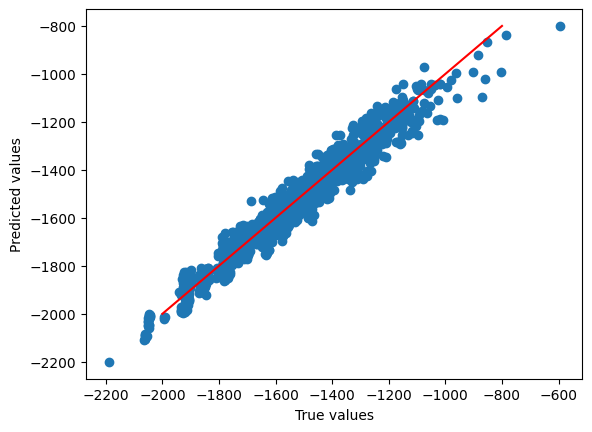

In [112]:
# predict on test set
model.eval()
preds = []
for data in test_loader:
    out = model(data)
    preds.append(out.detach().numpy())
preds = np.concatenate(preds)

# calculate R2 score
from sklearn.metrics import r2_score
trues = np.concatenate([data.y.detach().numpy() for data in test_loader])
print(f"r2_score: {r2_score(trues, preds)}")

# calculate RMSE
from sklearn.metrics import mean_squared_error
print(f"RMSE: {np.sqrt(mean_squared_error(trues, preds))}")

# plot a scatter plot of predicted vs. true values
# add a red line to show the perfect prediction
import matplotlib.pyplot as plt
plt.scatter(trues, preds)
plt.plot([-2000, -800], [-2000, -800], 'red')
plt.xlabel('True values')
plt.ylabel('Predicted values')

plt.savefig('gcnmodel.png')